<a href="https://colab.research.google.com/github/shuv50/IBM_Data_Science/blob/main/SpaceX_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage.

Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.

Here, we will create a machine learning pipeline to predict if the first stage will land given the data from the preceding labs.

# Objectives

Perform exploratory  Data Analysis and determine Training Labels

*   Create a column for the class
*   Standardize the data
*   Split into training data and test data

Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data

# Import Libraries

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import io
import httpx

# Auxilary Functions

In [3]:
# Plot confusion matrix
def plot_confusion_matrix(y,y_predict):
  cm = confusion_matrix(y, y_predict)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax);
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
  plt.show()

# Read SpaceX data

In [4]:
# Async fetch data
async def fetch_data(url):
  async with httpx.AsyncClient() as client:
    response = await client.get(url)
    if response.status_code == 200:
      return response.content  # Return binary content
    else:
      raise Exception(f"Failed to fetch data: {response.status_code}")

In [5]:
# SpaceX data
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = await fetch_data(spacex_url)
spacex_df = pd.read_csv(io.BytesIO(data))
spacex_df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
# Encoded SpaceX data
spacex_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
data = await fetch_data(spacex_url)
spacex_encoded_df = pd.read_csv(io.BytesIO(data))
spacex_encoded_df.head(5)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


# Dependent/Independent variables XY

## Dependent variable

Create a NumPy array from the column Class in data, by applying the method to_numpy() then assign it to the variable Y

In [7]:
# Dependent variable
Y = spacex_df['Class'].to_numpy()

## Independent variable

Standardize the data in X then reassign it to the variable X

In [8]:
# Feature scaling
transform = preprocessing.StandardScaler()
# Independent variable
X = transform.fit_transform(spacex_encoded_df)

# Split Test/Train Dataset

We split the data into training and testing data using the function train_test_split. <br>The training data is divided into validation data, a second set used for training data; then the models are trained and hyperparameters are selected using the function GridSearchCV.

In [9]:
# Test/Train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Machine Learning

## Logistic Regression

Create a Logistic Regression object with GridSearchCV to find the best parameters from the dictionary parameters.

We output the GridSearchCV object for logistic regression.
<br>We display the best parameters using the data attribute best_params_ and the accuracy on the validation data using the data attribute best_score_.

Calculate the accuracy on the test data

In [10]:
# Logistic Regression
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

# Accuracy
print("Tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("Best accuracy :",logreg_cv.best_score_)
test_accuracy = logreg_cv.score(X_test, Y_test)
print("Accuracy :", test_accuracy)
acc = {}
acc['Logistic Regression'] = test_accuracy

Tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best accuracy : 0.8464285714285713
Accuracy : 0.8333333333333334


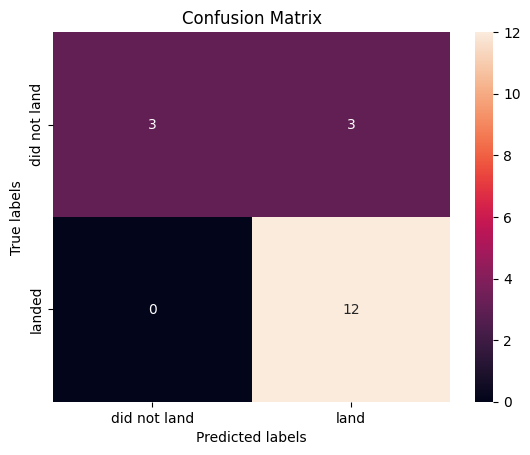

In [11]:
# Confusion Matrix
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [12]:
confusion_matrix(Y_test, yhat)

array([[ 3,  3],
       [ 0, 12]])

## Support Vector Machine

Create a Support Vector Machine object with GridSearchCV to find the best parameters from the dictionary parameters.

In [57]:
# Support Vector Machine
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

# Accuracy
print("Tuned hyperparameters :(best parameters) ",svm_cv.best_params_)
print("Best accuracy :",svm_cv.best_score_)
test_accuracy = svm_cv.score(X_test, Y_test)
print("Accuracy :",test_accuracy)
acc['Support Vector Machine'] = test_accuracy

Tuned hyperparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Best accuracy : 0.8482142857142856
Accuracy : 0.8333333333333334


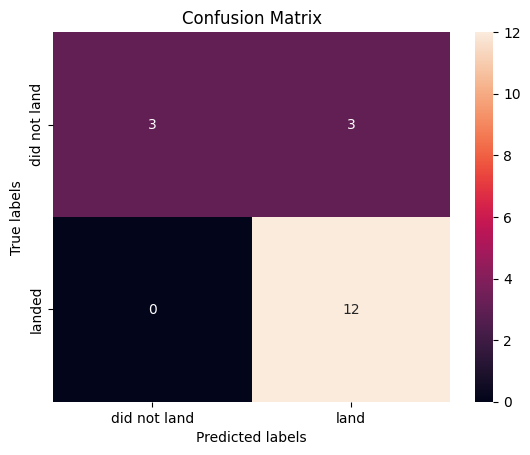

In [58]:
# Confusion Matrix
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Decision Tree Classifier

Create a Decision Tree Classifier object with GridSearchCV to find the best parameters from the dictionary parameters.

In [59]:
# Decision Tree Classifier
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

# Accuracy
print("Tuned hyperparameters :(best parameters) ",tree_cv.best_params_)
print("Best accuracy :",tree_cv.best_score_)
test_accuracy = tree_cv.score(X_test, Y_test)
print("Accuracy :",test_accuracy)
acc['Decision Tree Classifier'] = test_accuracy

Tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Best accuracy : 0.875
Accuracy : 0.7777777777777778


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

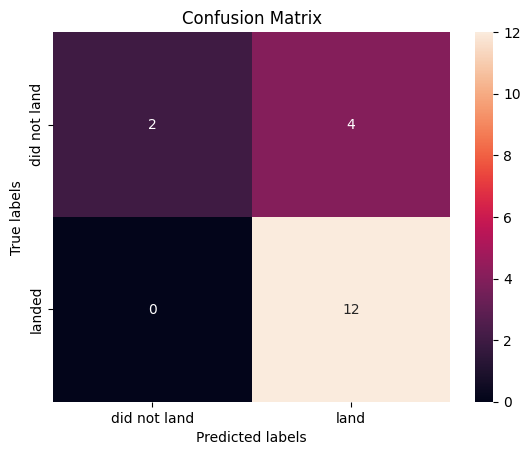

In [61]:
# Confusion Matrix
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## K-Nearest Neighbour

Create a Decision Tree Classifier object with GridSearchCV to find the best parameters from the dictionary parameters.

In [62]:
# K-Nearest Neighbour
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

# Accuracy
print("Tuned hyperparameters :(best parameters) ",knn_cv.best_params_)
print("Best accuracy :",knn_cv.best_score_)
test_accuracy = knn_cv.score(X_test, Y_test)
print("Accuracy :",test_accuracy)
acc['K-Nearest Neighbour'] = test_accuracy

Tuned hyperparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Best accuracy : 0.8482142857142858
Accuracy : 0.8333333333333334


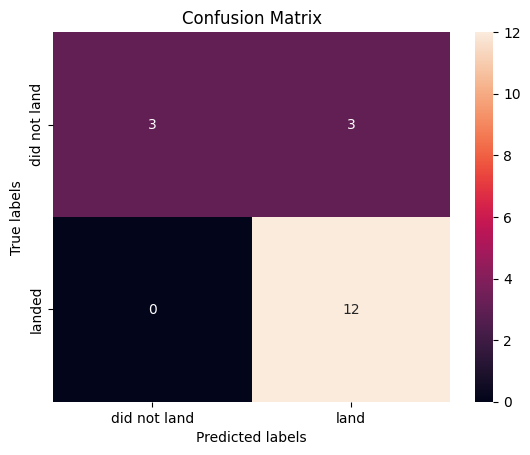

In [63]:
# Confusion Matrix
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

# Result

View classification algorithms accuracy and find the best performing algorithm

## Accuracy

In [64]:
# Accuracy
acc_df = pd.DataFrame(list(acc.items()),columns = ['Algorithm','Accuracy'])
acc_df

,Algorithm,Accuracy
0,Logistic Regression,0.833333
1,Support Vector Machine,0.833333
2,Decision Tree Classifier,0.777778
3,K-Nearest Neighbour,0.833333


## Algorithm vs Accuracy

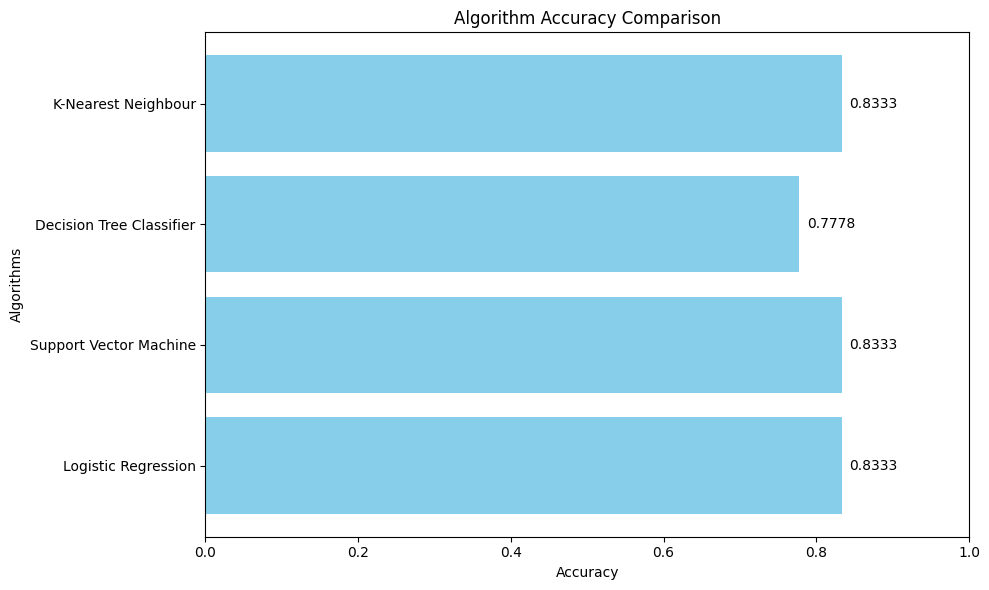

In [71]:
# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(acc_df['Algorithm'], acc_df['Accuracy'], color='skyblue')
plt.xlabel("Accuracy")
plt.ylabel("Algorithms")
plt.title("Algorithm Accuracy Comparison")
plt.xlim(0, 1)

# Add accuracy values on top of each bar
for i, v in enumerate(acc_df['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center', fontsize=10)
plt.tight_layout()
plt.show()

## Best Algorithm

In [66]:
# Create a DataFrame from the 'acc' dictionary
acc_df = pd.DataFrame(list(acc.items()), columns=['Algorithm', 'Accuracy'])

# Algorithm with the highest accuracy
best_algorithm = acc_df.loc[acc_df['Accuracy'].idxmax()]
print("The best algorithm is:", best_algorithm['Algorithm'])
print("Accuracy:", best_algorithm['Accuracy'])


The best algorithm is: Logistic Regression
Accuracy: 0.8333333333333334
